# Homework 5

**Due: 03/09/2018** (Friday 9th March at 11:59pm).

## Instructions

+ In any case, develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you can either:
    
    - Type the answer using the built-in latex capabilities. In this case, simply export the notebook as a pdf and upload it on gradescope; or
    - you can print the notebook (after you are done with all the code), write your answers by hand, scan, turn your response to a single pdf, and upload on gradescope. 

+ The total homework points are 100. Please note that the problems are not weighed equally.

**Note**: Please match all the pages corresponding to each of the questions when you submit on gradescope. 

## Student details

+ **First Name:**
+ **Last Name:**
+ **Email:**

## Readings

Before attempting the homework, it is probably a good idea to:
+ Review the slides of lectures 13 and 14; and
+ Review the corresponding lecture handouts.

$\newcommand{\x}{\mathbf{x}}$

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
import fipy
import GPy
%matplotlib inline

In [14]:
import numpy as np
import scipy

class KarhunenLoeveExpansion(object):
    
    """
    A class representing the Karhunen Loeve Expansion of a Gaussian random field.
    It uses the Nystrom approximation to do it.
    
    Arguments:
        k      -     The covariance function.
        Xq     -     Quadrature points for the Nystrom approximation.
        wq     -     Quadrature weights for the Nystrom approximation.
        alpha  -     The percentage of the energy of the field that you want to keep.
        X      -     Observed inputs (optional).
        Y      -     Observed field values (optional).
    """
    
    def __init__(self, k=None, Xq=None, wq=None, nq=200, alpha=0.9, X=None, Y=None):
        if k is None:
            # If the kernel is not provided, we pick a default one
            k = GPy.kern.Exponential(2, ARD=True, lengthscale=[0.1, 0.5], variance=1.0)
        self.k = k
        if Xq is None:
            if k.input_dim == 1:
                Xq = np.linspace(0, 1, nq)[:, None]
                wq = np.ones((nq, )) / nq
            elif k.input_dim == 2:
                nq = int(np.sqrt(nq))
                x = np.linspace(0, 1, nq)
                X1, X2 = np.meshgrid(x, x)
                Xq = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
                wq = np.ones((nq ** 2, )) / nq ** 2
            else:
                raise NotImplementedError('For more than 2D, please supply quadrature points and weights.')
        self.Xq = Xq
        self.wq = wq
        self.k = k
        self.alpha = alpha
        self.X = X
        self.Y = Y
        # If we have some observed data, we need to use the posterior covariance
        if X is not None:
            gpr = GPy.models.GPRegression(X, Y[:, None], k)
            gpr.likelihood.variance = 1e-12
            self.gpr = gpr
            Kq = gpr.predict(Xq, full_cov=True)[1]
        else:
            Kq = k.K(Xq)
        B = np.einsum('ij,j->ij', Kq, wq)
        lam, v = scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam[lam <= 0.] = 0.
        energy = np.cumsum(lam) / np.sum(lam)
        i_end = np.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        self.lam = lam
        self.sqrt_lam = np.sqrt(lam)
        self.v = v
        self.energy = energy
        self.num_z = i_end
        
    def eval_phi(self, x):
        """
        Evaluate the eigenfunctions at x.
        """
        if self.X is not None:
            nq = self.Xq.shape[0]
            Xf = np.vstack([self.Xq, x])
            m, C = self.gpr.predict(Xf, full_cov=True)
            Kc = C[:nq, nq:].T
            self.tmp_mu = m[nq:, :].flatten()
        else:
            Kc = self.k.K(x, self.Xq)
            self.tmp_mu = 0.
        phi = np.einsum("i,ji,j,rj->ri", 1. / self.lam, self.v, self.wq**0.5, Kc)
        return phi
    
    def __call__(self, x, xi):
        """
        Evaluate the expansion at x and xi.
        """
        phi = self.eval_phi(x)
        return self.tmp_mu + np.dot(phi, xi * self.sqrt_lam)

class Elliptic2DSolver(object):
    def __init__(self, nx=100, ny=100, value_left=1.,
                 value_right=0., value_top=0., value_bottom=0.):
        """
        ::param nx:: Number of cells in the x direction.
        ::param ny:: Number of cells in the y direction.
        ::param value_left:: Boundary condition on the left face.
        ::param value_right:: Boundary condition on the right face.
        ::param value_top:: Boundary condition on the top face.
        ::param value_bottom:: Boundary condition on the bottom face.
        """
        #set domain dimensions
        self.nx = nx
        self.ny = ny
        self.dx = 1. / nx
        self.dy = 1. / ny
        
        #define mesh
        self.mesh = fipy.Grid2D(nx=self.nx, ny=self.ny, dx=self.dx, dy=self.dy)
        
        #get all the face centers 
        X, Y = self.mesh.faceCenters.value
        X = X[:, None]
        Y = Y[:, None]
        self.Xface = np.hstack([X,Y])

        #define cell and face variables 
        self.phi = fipy.CellVariable(name='$T(x)$', mesh=self.mesh, value=1.)
        self.C = fipy.FaceVariable(name='$C(x)$', mesh=self.mesh, value=1.)
        self.source=fipy.CellVariable(name='$f(x)$', mesh=self.mesh, value=0.)
        
        #apply boundary conditions
        #dirichet
        self.phi.constrain(value_left, self.mesh.facesLeft)
        self.phi.constrain(value_right, self.mesh.facesRight)
        
        #homogeneous Neumann
        self.phi.faceGrad.constrain(value_top, self.mesh.facesTop)
        self.phi.faceGrad.constrain(value_bottom, self.mesh.facesBottom)
        
        #setup the diffusion problem
        self.eq = -fipy.DiffusionTerm(coeff=self.C) == self.source
        
    def set_coeff(self, C):
        """
        Initialize the random conductivity field.
        """
        self.C.setValue(C)
    
    def solve(self):
        self.eq.solve(var=self.phi)
        #return self.phi.value
    
    def __call__(self):
        self.solve()
        return self.phi.value.flatten()

def sample(solver, kle, nsamples=1):
    """
    solver -> An object of the Elliptic2DSolver object. 
    kle -> An object of the KarhunenLoeveExpansion class.
    nsamples -> Number of samples of the PDE solution to generate.
    """
    samples = np.zeros((nsamples, solver.nx*solver.ny))
    num_z = kle.num_z
    for i in xrange(nsamples):
        z = np.random.randn(num_z)
        coeff = kle(solver.Xface, z)
        solver.set_coeff(np.exp(coeff))
        sample = solver()
        samples[i] = sample
    return samples

# Problem 1 - Uncertainty propagation in 2-D stochastic elliptic partial differential equation

In lecture 13, we discussed the Monte Carlo method as a technique to compute high-dimensional integrals and used this technique to propagate uncertainties through physical models. 

Consider the following stochastic partial differential equation:

$$
\nabla (a(\x, \omega) \nabla u(\x, \omega)) = 0, \ \forall \x \in [0, 1]^2,
$$
with boundary conditions:
$$
u|_{x_1 = 0} = 1, \\
u|_{x_1 = 1} = 0, \\
\frac{\partial u}{\partial n}|_{x_2 = 0} = 0, \\
\frac{\partial u}{\partial n}|_{x_2 = 1} = 0.
$$

This is a general model for diffusion problems and shows up in a wide variety of applications, such as heat conduction, subsurface flows, electromagnetics etc. It is often the case that one is uncertain about the diffusion coefficient $a(\mathbf{x},\omega)$. 
This is why we write $a(\mathbf{x},\omega)$ instead of just $a(\mathbf{x})$.
The $\omega$ is there to characterize the unknown state of nature.
In other words, $a(\mathbf{x},\omega)$ is a random field (a stochastic process parametrized by space).
We will learn about random fields in a future lecture.
For now, it sufficies to know that we can describe this random field in terms of independent standard normal random variables using what is known as the Karhunen-Loève expansion.

First, notice that $a(\mathbf{x},\omega)$ is necessarily a positive quantity.
It does not make physical sense for the diffusion coefficient of a material to be negative.
(There are more restrictions that are required for a solution to exist, but we are going to silently assume that they are true).
Therefore, it is much more convenient to work with the logarithm of $a(\mathbf{x}, \omega)$ which can take both positive and negative values.
The Karhunen-Loève theorem applied on $\log a(\mathbf{x},\omega)$ states that any random field that:
$$
\log a(x,\omega) \approx m(x) + \sum_{k=1}^K Z_k(\omega) \phi_k(x),
$$
where $m(x)$ is a *mean* function, the $\phi_k(x)$ are some *special eigenfunctions*, and $Z_k$ are standard normal.
We have implemented this for you, so you can just use it.
It is in the class ``KarhunenLoeveExpansion``.
We have also implemented a finite volume solver for the PDE given a specific diffusion coefficient $a(\mathbf{x},\omega)$.
This is in the class named ``Elliptic2DSolver``.
Let's see how these two objects work.

Number of stochastic dimensions for representing a: 62


ValueError: cannot reshape array of size 20200 into shape (100,100)

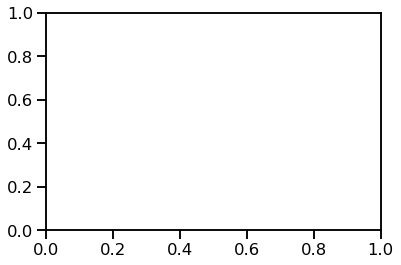

In [21]:
# This is the object that gives us the log a(x, omega)
kle = KarhunenLoeveExpansion()
# This is the object that solves the PDE
solver = Elliptic2DSolver()
# The number of random variables needed by KLE is:
print('Number of stochastic dimensions for representing a: {0:d}'.format(kle.num_z))
# Let's sample a diffusion coefficient field at the centers of the finite volume scheme:
z = np.random.randn(kle.num_z) 
log_a_sample_vec = kle(solver.Xface, z) # The sample as a flat vector
# Let's plot the sample as a contour
fig, ax = plt.subplots()
X = solver.Xface[:, 0].reshape((solver.nx, solver.ny)) # x coordinates of centers
Y = solver.Xface[:, 1].reshape((solver.nx, solver.ny)) # y coordinates of centers
log_a_sample = log_a_sample_vec.reshape((solver.nx, solver.ny))
ax.contourf(X, Y, log_a_sample)

### Part b.

The class ```Elliptic2DSolver``` defined at the top of this notebook can be used to solve this PDE. Additionally, we have provided a function ```sample``` to generate as many samples of the stochastic PDE solution as you want. 

Establish the ground truth on the mean and variance of the solution $u$ of the PDE using 100000 Monte Carlo samples of the uncertain diffusion field. Show contour plots for mean and 2 standard deviation fields of the solution.

### Part c.

Propagate uncertainty through the model using 10, 100, 1,000, and 10,000 MC samples and plot the *relative* L2 error in the estimation of the mean and the variance. The relative L2 error is defined as follows:

##### Relative L2 Error
Let $\mathbf{y}_{\mbox{true}}$ be the *ground truth vector* and $\hat{\mathbf{y}}$ be the *estimated vector*.
The relattive L2 error is defined to be:
$$
L_2[\mathbf{y}_{\mbox{true}},\hat{\mathbf{y}}] = \frac{\parallel\mathbf{y}_{\mbox{true}}-\hat{\mathbf{y}} \parallel_2}{\parallel \mathbf{y}_{\mbox{true}}\parallel_2},
$$
where $\parallel\cdot\parallel_2$ is the standard Euclidean norm.

### Part d.

Repeat c. 100 times (if it takes too much time do 10) to get the uncertainty induced by the fact that MC estimates are noisy. You can use the function [numpy.percentile](http://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html) to get lower and upper uncertainty bars for the evolution of the L2 error.

# Problem 2  - Latin hypercube sampling (LHS)


Repeat the tasks in problem 1 parts (b), (c) and (d) with Latin hypercube sampling (LHS). Compare the LHS results with MCS results.

#### Hint:
Recall that we has used the Latin Hypercube sampler in class to generate uniform samples in the unit square - $[0, 1]^2$. It is trivial to transform these uniform samples into standard normal distributed samples. We just need the inverse CDF method discussed in Lecture 5. Also recall, from homework 2, that ```scipy.stat.norm.ppf``` implements the inverse CDF of the standard normal random variable. 